#### Cloudtrail loader

This notebook ingests Cloudtrail logs from a folder into a dataframe and plots them by several fields so you can see at a glance if the data range and shape is as expected. The charts polt time series histograms of event source, event name (action,) and errors. In the charts, you can see data plots where there was a concomitant spike in both events and errors which often occurs when there is discovery activity followed by lateral movement and exfiltration. After loading, you can export to csv for ingestion into ML or hunting notebooks, or run additional analytics here.


In [3]:
import pandas as pd
import glob
import os
import json

In [4]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.expand_frame_repr', False)

In [406]:
# Define the folder containing Cloudtrail logs in root_directory and read files

root_directory = '02'

def process_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    records = data.get('Records', [])
    cdf = pd.json_normalize(records)
    return cdf

def process_all_json_files(root_directory):
    all_files = glob.glob(os.path.join(root_directory, '**', '*.json'), recursive=True)
    all_dfs = []
    for file_path in all_files:
        cdf = process_json_file(file_path)
        all_dfs.append(df)
    final_df = pd.concat(all_dfs, ignore_index=True)
    return final_df

cloudtrail = process_all_json_files(root_directory)

In [420]:

cloudtrail = cloudtrail.where(pd.notnull(cloudtrail), None)
cloudtrail['eventTime'] = pd.to_datetime(cloudtrail['eventTime'])
cloudtrail = df.sort_values(by='eventTime', ascending=True).reset_index(drop=True)

In [422]:
# Assemble the response parameters
response_parameters_columns = [col for col in cloudtrail.columns if col.startswith('responseElements.')]
response_data = cloudtrail[response_parameters_columns].apply(lambda row: row.dropna().to_dict(), axis=1).apply(json.dumps)
response_data = response_data.rename('response')

cloudtrail = cloudtrail.drop(columns=response_parameters_columns)
cloudtrail = pd.concat([cloudtrail, response_data], axis=1)

In [424]:
# Assemble the request parameters
request_parameters_columns = [col for col in cloudtrail.columns if col.startswith('requestParameters.')]
request_data = cloudtrail[request_parameters_columns].apply(lambda row: row.dropna().to_dict(), axis=1).apply(json.dumps)
request_data = request_data.rename('request')

cloudtrail = cloudtrail.drop(columns=request_parameters_columns)
cloudtrail = pd.concat([cloudtrail, request_data], axis=1)

In [426]:
# Assemble the aed field
aed_columns = [col for col in cloudtrail.columns if col.startswith('additionalEventData.')]
aed_data = cloudtrail[aed_columns].apply(lambda row: row.dropna().to_dict(), axis=1).apply(json.dumps)
aed_data = aed_data.rename('aed')

cloudtrail = cloudtrail.drop(columns=aed_columns)
cloudtrail = pd.concat([df, aed_data], axis=1)

In [428]:
# Spot check that the above fields have been populated (this notebook assumes original native Couldtrail files)
fields = ['response', 'request', 'aed', 'errorCode', 'errorMessage']

for field in fields:
    if field in cloudtrail.columns:
        print(f"Number of unique values in '{field}': {df[field].nunique()}")
    else:
        print(f"Field '{field}' does not exist in the DataFrame.")

Number of unique values in 'response': response    53
response     1
response     1
dtype: int64
Number of unique values in 'request': request    2684
request       1
request       1
request       1
dtype: int64
Number of unique values in 'aed': aed    2123
aed       1
dtype: int64
Number of unique values in 'errorCode': 21
Number of unique values in 'errorMessage': 27


In [432]:
# Timestamp and date fields 
cloudtrail['eventTime'] = pd.to_datetime(df['eventTime'])
cloudtrail['month'] = df['eventTime'].dt.month
cloudtrail['date'] = df['eventTime'].dt.strftime('%m-%d')  


In [434]:
# Optional export to csv for sharing / faster loading
cloudtrail.to_csv('cloudtrail-export.tsv', sep='\t', index=False)

In [442]:
# Groups used by the plots

source_month = cloudtrail.groupby(['month', 'eventSource']).size().reset_index(name='count')
source_date = cloudtrail.groupby(['date', 'eventSource']).size().reset_index(name='count')
action_month = cloudtrail.groupby(['month', 'eventName']).size().reset_index(name='count')
action_date = cloudtrail.groupby(['date', 'eventName']).size().reset_index(name='count')
code_month = cloudtrail.groupby(['month', 'errorCode']).size().reset_index(name='count')
code_date = cloudtrail.groupby(['date', 'errorCode']).size().reset_index(name='count')
error_month = cloudtrail.groupby(['month', 'errorMessage']).size().reset_index(name='count')
error_date = cloudtrail.groupby(['date', 'errorMessage']).size().reset_index(name='count')

print(source_month.head())
print(source_date.head())

   month                eventSource  count
0    1.0  autoscaling.amazonaws.com      1
1    1.0           ce.amazonaws.com      2
2    1.0   cloudtrail.amazonaws.com     13
3    1.0       config.amazonaws.com      4
4    1.0          ec2.amazonaws.com    213
    date                         eventSource  count
0  01-06                    ce.amazonaws.com      2
1  01-06            cloudtrail.amazonaws.com     13
2  01-06                config.amazonaws.com      4
3  01-06                   ec2.amazonaws.com    192
4  01-06  elasticloadbalancing.amazonaws.com      4


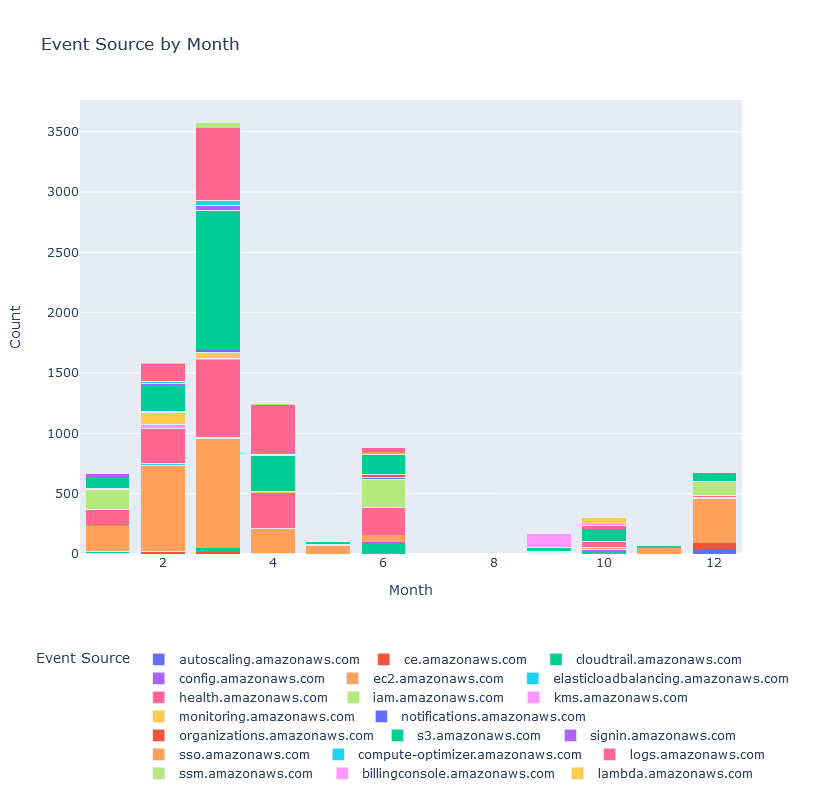

In [444]:
# Plot event source

fig = px.bar(
    source_month, 
    x="month", 
    y="count", 
    color="eventSource", 
    title="Event Source by Month",
    labels={"month": "Month", "count": "Count", "eventSource": "Event Source"},
    hover_data={"count": True, "eventSource": True}
)

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    legend=dict(title='Event Source', orientation="h", x=0.5, xanchor="center", y=-0.2),
    height=800
)

fig.show()

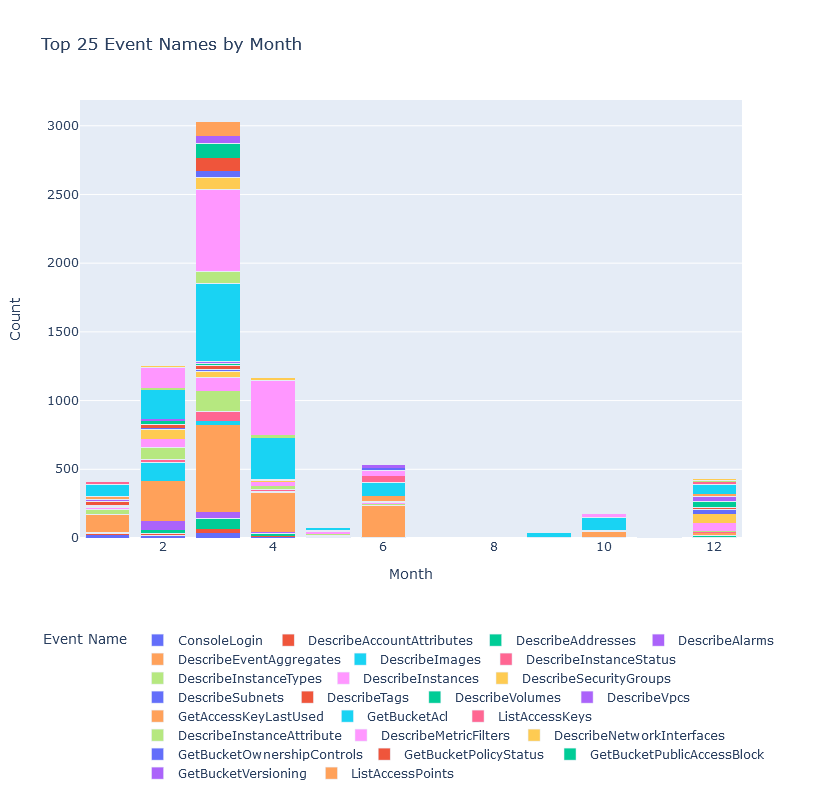

In [446]:
# Plot event name

top_event_names = (
    action_month.groupby('eventName')['count']
    .sum()
    .reset_index()
    .sort_values(by='count', ascending=False)
    .head(25)
)

filtered_action_month = action_month[action_month['eventName'].isin(top_event_names['eventName'])]

fig = px.bar(
    filtered_action_month, 
    x="month", 
    y="count", 
    color="eventName", 
    title="Top 25 Event Names by Month",
    labels={"month": "Month", "count": "Count", "eventName": "Event Name"},
    hover_data={"count": True, "eventName": True}
)

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    legend=dict(title='Event Name', orientation="h", x=0.5, xanchor="center", y=-0.2),
    height=800  
)

fig.show()

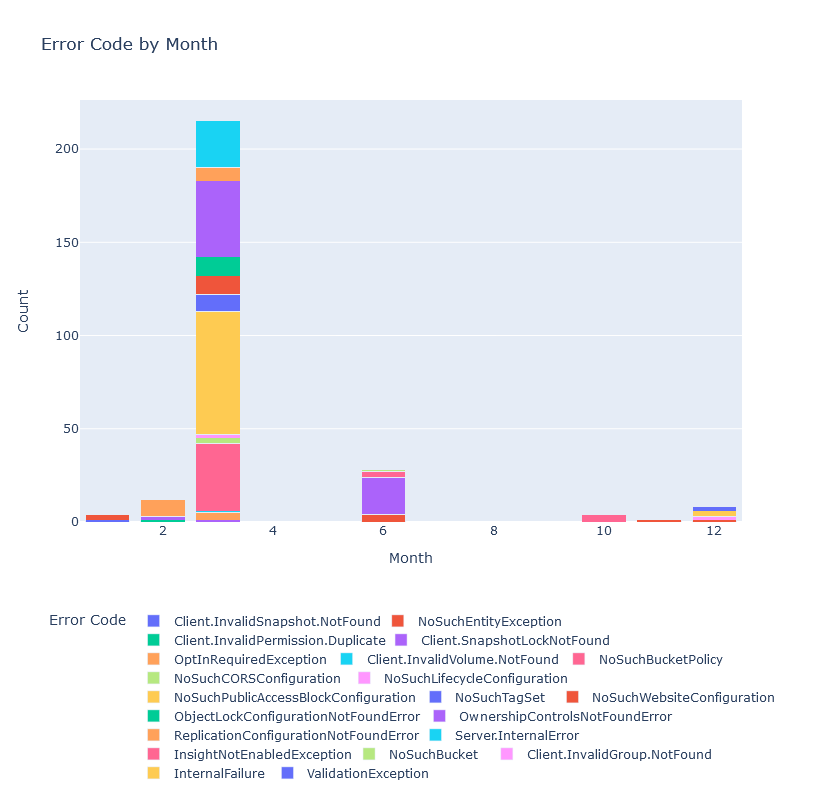

In [448]:
# Plot error codes

fig = px.bar(
    code_month, 
    x="month", 
    y="count", 
    color="errorCode", 
    title="Error Code by Month",
    labels={"month": "Month", "count": "Count", "errorCode": "Event Source"},
    hover_data={"count": True, "errorCode": True}
)

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    legend=dict(title='Error Code', orientation="h", x=0.5, xanchor="center", y=-0.2),
    height=800
)
fig.show()

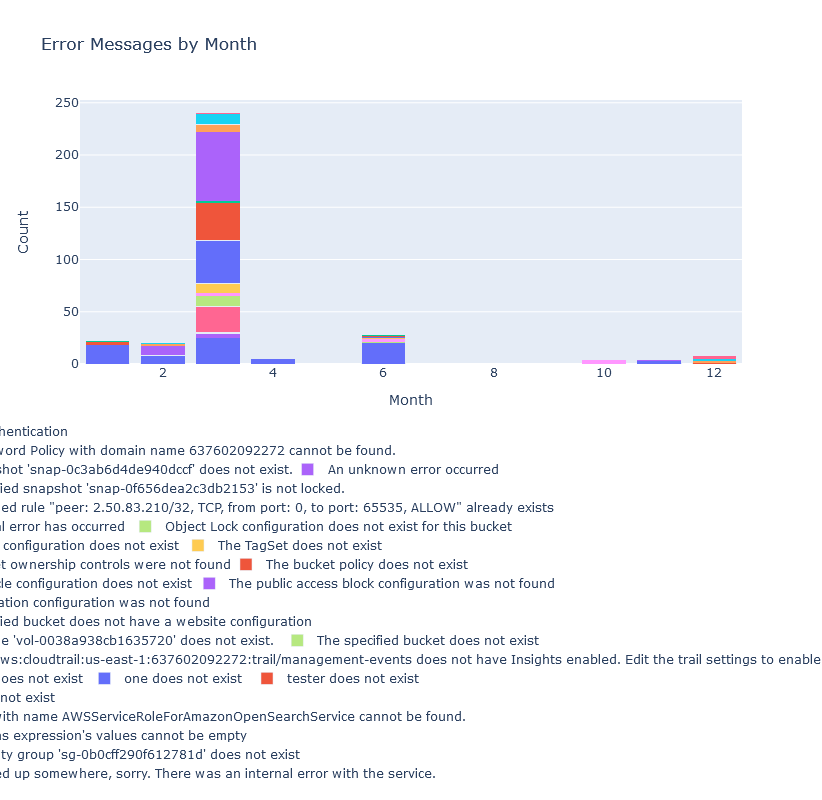

In [450]:
# Plot error messages

fig = px.bar(
    error_month, 
    x="month", 
    y="count", 
    color="errorMessage", 
    title="Error Messages by Month",
    labels={"month": "Month", "count": "Count", "errorMessage": "Error Message"},
    hover_data={"count": True, "errorMessage": True}
)

fig.update_layout(
    barmode='stack',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    legend=dict(title='Error Message', orientation="h", x=0.5, xanchor="center", y=-0.2),
    height=800
)

fig.show()